In [1]:
import csv
import os
import re
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import simfin as sf
from simfin.names import * 
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# get data from simfin
sf.set_data_dir('~/simfin_data/')
companies = sf.load(dataset='companies', market='us')
sector = sf.load(dataset='industries')
share_prices = sf.load_shareprices(variant='daily', market='us')
income = sf.load_income(variant='annual', market='us')
income_banks = sf.load_income_banks(variant='annual', market='us')
cash_flow = sf.load_cashflow(variant='annual', market='us')
cash_flow_banks = sf.load_cashflow_banks(variant='annual', market='us')
income_statement = sf.load_income(variant='annual', market='us')

Dataset "us-companies" on disk (0 days old), loading.
Dataset "industries" on disk (0 days old), loading.
Dataset "us-shareprices-daily" on disk (2 days old), loading.
Dataset "us-income-annual" on disk (0 days old), loading.
Dataset "us-income-banks-annual" on disk (0 days old), loading.
Dataset "us-cashflow-annual" on disk (0 days old), loading.
Dataset "us-cashflow-banks-annual" on disk (0 days old), loading.
Dataset "us-income-annual" on disk (0 days old), loading.


In [3]:
# perform share buyback analysis over 2000 stocks
stocks = pd.merge(companies, sector, how='left', on='IndustryId')
spending_revenue = pd.DataFrame()
index_num = 0
for index, row in stocks.iterrows():
    skipped = False
    if row['Sector'] == 'Financial Services':
        if row['Industry'].split(" ")[0] == 'Insurance':
            skipped = True
            continue
        else:
            try:
                fcf = cash_flow_banks.loc[row['Ticker']][[NET_CHG_CASH]]
                revenue = income_banks.loc[row['Ticker']][[REVENUE, NET_INCOME]]
            except:
                skipped = True
                continue
    else:
        try:
            fcf = cash_flow.loc[row['Ticker']][[NET_CHG_CASH]]
            revenue = income.loc[row['Ticker']][[REVENUE, NET_INCOME]]
        except:
            skipped = True
            continue
        
    spending = pd.merge(fcf, revenue, on='Report Date')
    spending['Ticker'] = row['Ticker']
    spending['Sector'] = row['Sector']
    spending['Industry'] = row['Industry']
    spending = spending.sort_index()
    spending_revenue = pd.concat([spending_revenue, spending])
spending_revenue = spending_revenue.dropna()

In [19]:
# calculate fcf/net income ratio 
spending_revenue['FCFSpent%'] = 100*(spending_revenue['Net Change in Cash']/spending_revenue['Net Income'])
# calculate net income/revenue (net profit margin)
spending_revenue['ProfitMargin%'] = 100*(spending_revenue['Net Income']/spending_revenue['Revenue'])
spending_revenue = spending_revenue.replace([np.inf, -np.inf], np.nan)
spending_revenue = spending_revenue.dropna()
final_table = spending_revenue.loc[(spending_revenue['ProfitMargin%'] >= -100.0) &
                                   (spending_revenue['ProfitMargin%'] <= 100.0) & 
                                   (spending_revenue['FCFSpent%'] >= -100.0) &
                                   (spending_revenue['FCFSpent%'] <= 100.0)]

In [15]:
# log transform data 
# final_table['ProfitMargin%'] = final_table['ProfitMargin%'].apply(lambda x: np.log(x+1))
# final_table['FCFSpent%'] = final_table['FCFSpent%'].apply(lambda x: np.log(x+1))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
print('ProfitMargin% mean: ' + str("{0:.2f}".format(final_table['ProfitMargin%'].mean())) + '%')
print('FCFSpent% mean: ' + str("{0:.2f}".format(final_table['FCFSpent%'].mean())) + '%')

ProfitMargin% mean: 6.31%
FCFSpent% mean: 4.85%


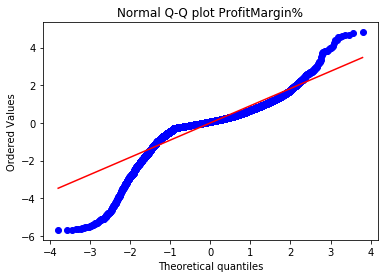

In [21]:
z = (final_table['ProfitMargin%']-np.mean(final_table['ProfitMargin%']))/np.std(final_table['ProfitMargin%'])

stats.probplot(z, dist="norm", plot=plt)
plt.title("Normal Q-Q plot ProfitMargin%")
plt.show()

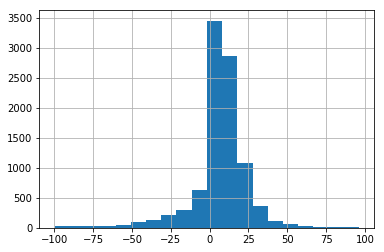

In [24]:
hist = final_table['ProfitMargin%'].hist(bins=20)

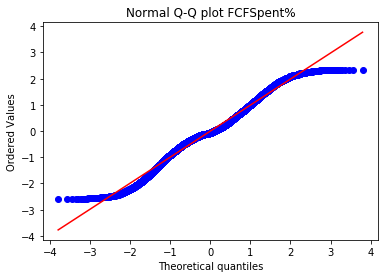

In [22]:
z = (final_table['FCFSpent%']-np.mean(final_table['FCFSpent%']))/np.std(final_table['FCFSpent%'])

stats.probplot(z, dist="norm", plot=plt)
plt.title("Normal Q-Q plot FCFSpent%")
plt.show()

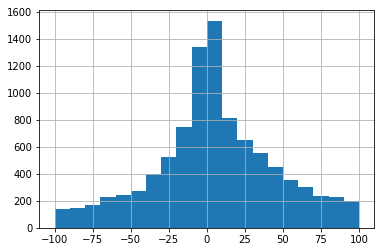

In [25]:
hist = final_table['FCFSpent%'].hist(bins=20)

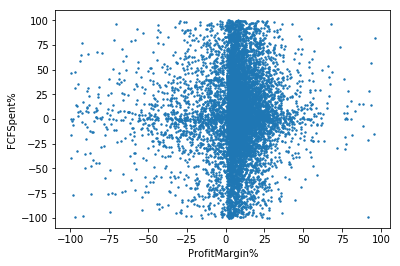

In [23]:
ax = final_table.plot.scatter(x='ProfitMargin%', y='FCFSpent%', s=2)

In [10]:
final_table.to_csv("spending_revenue.csv")

In [11]:
def z_score_normalize(training_dataset, test_dataset, columns_to_normalize):
    combined = pandas.concat([training_dataset, test_dataset])
    for i in [x for x in training_dataset.columns if x in columns_to_normalize]:
        mean = combined[i].mean()
        std = combined[i].std(ddof=0)
        test_dataset[i] = (test_dataset[i] - mean) / std
        training_dataset[i] = (training_dataset[i] - mean) / std

    return training_dataset, test_dataset